In [44]:
import os 
import torch
from monai.networks.nets import DenseNet121
from monai.data import DataLoader, ImageDataset
from monai.transforms import Resize, EnsureChannelFirst, Compose, ScaleIntensity
import numpy as np
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

In [45]:
fold=1
model_path = f'/data/Ziliang/IPMN/t2/exp_res/densenet121/fold{fold}_best_auc_model.pth'
test_file_dir = f'/data/Ziliang/IPMN/t2/FOLDS/Fold{fold}/test'

In [46]:
def get_test_list(test_file_dir:os.PathLike):
    test_file = []
    test_label = []
    label_dic = {'low grade':1,'normal':0,'high grade':2}
    for cls in os.listdir(test_file_dir):
        cls_path = os.path.join(test_file_dir,cls+'/')
        for file in os.listdir(cls_path):
            test_file.append(os.path.join(cls_path,file))
            test_label.append(label_dic[cls])
    return test_file, test_label
test_file,test_label = get_test_list(test_file_dir)

In [47]:
densenet = DenseNet121(
        spatial_dims=3,  # 3D input
        in_channels=1,   # Typically for grayscale (e.g., MRI/CT scans), change to 3 for RGB
        out_channels=3   # Adjust for binary or multi-class segmentation/classification
    )

densenet.load_state_dict(torch.load(model_path, map_location='cpu', weights_only=True))
densenet.to('cuda')
test_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize((96, 96, 96))])
test_ds = ImageDataset(image_files=test_file, labels=test_label, transform=test_transforms)
test_dataloader = DataLoader(test_ds, batch_size=1, shuffle=False,num_workers=1)

In [48]:
def get_densenet_probabilities(densenet_model, test_dataloader):
    prediction_list = []
    with torch.no_grad(): 
        progress_bar = tqdm(test_dataloader, desc="Testing")
    for X, y in progress_bar:
        X = X.to('cuda')
        pred = densenet_model(X)
        prediction_list.append(torch.nn.functional.softmax(pred, dim=-1).cpu().detach().numpy().reshape(3))
    return np.array(prediction_list)

In [49]:
predicted_probs = get_densenet_probabilities(densenet, test_dataloader)

Testing:   0%|          | 0/132 [00:00<?, ?it/s]

Testing: 100%|██████████| 132/132 [00:11<00:00, 11.01it/s]


In [50]:
true_labels_binarized = label_binarize(test_label, classes=[0, 1, 2])

In [55]:
n_classes = true_labels_binarized.shape[1]
auc_per_class = []

for i in range(n_classes):
    # Check if the class has at least one positive and one negative sample
    if np.any(true_labels_binarized[:, i] == 1) and np.any(true_labels_binarized[:, i] == 0):
        auc = roc_auc_score(true_labels_binarized[:, i], predicted_probs[:, i],average='macro',multi_class='ovr')
        auc_per_class.append((i, auc))
    else:
        auc_per_class.append((i, None))  # No AUC for this class due to lack of variety

# Print AUC results
for class_idx, auc in auc_per_class:
    if auc is not None:
        print(f"AUC for class {class_idx}: {auc:.2f}")
    else:
        print(f"AUC for class {class_idx}: Not computable (no positive/negative samples).")

AUC for class 0: 0.40
AUC for class 1: 0.70
AUC for class 2: 0.52


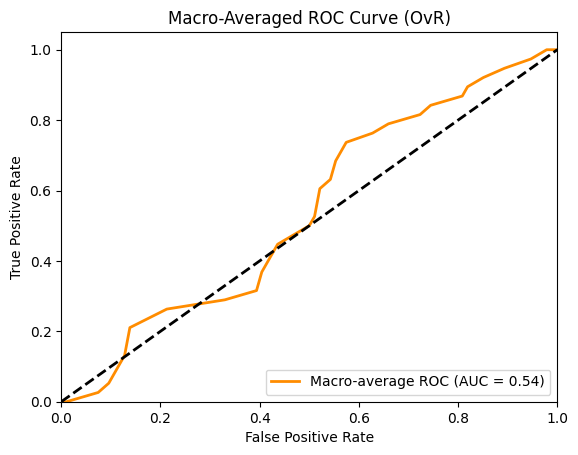

In [ ]:
fpr = {}
tpr = {}
roc_auc = {}

for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, 2], np.array(predicted_probs)[:, 2])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(1)]))

# Interpolate all ROC curves
mean_tpr = np.zeros_like(all_fpr)
for i in range(1):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it across classes
mean_tpr /= 1

# Compute the macro-average AUC
roc_auc_ovr = auc(all_fpr, mean_tpr)

# Plot the ROC Curve
plt.figure()
plt.plot(all_fpr, mean_tpr, color='darkorange', lw=2,
         label=f'Macro-average ROC (AUC = {roc_auc_ovr:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-Averaged ROC Curve (OvR)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
X, y = make_multilabel_classification(random_state=0)
inner_clf = LogisticRegression(solver="liblinear", random_state=0)
clf = MultiOutputClassifier(inner_clf).fit(X, y)
y_score = np.transpose([y_pred[:, 1] for y_pred in clf.predict_proba(X)])
roc_auc_score(y, y_score, average=None)

array([0.82664884, 0.86034414, 0.94181818, 0.8502652 , 0.94809095])

AttributeError: 'list' object has no attribute 'shape'